In [3]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic, shapelets
from gigalens.tf.profiles.mass import epl, shear, sis
import gigalens
sns.set_style("whitegrid")
tfd = tfp.distributions

/tmp/ipykernel_42869/1996586253.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol, resid, _, _ = np.linalg.lstsq(X.T, Y)


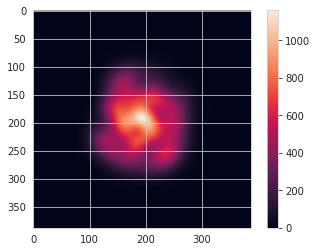

In [38]:
img = plt.imread('spiral.jpeg')
img = img[:,131:-131]
img = np.sqrt(img[...,1].astype(np.float32))
img -= np.median(img[:20,:20])
img *= 100
from skimage.transform import downscale_local_mean
img = downscale_local_mean(img, (5,5))
img = np.pad(img, [(100, 100), (100, 100)], mode='constant')
grid = np.linspace(-1,1,len(img)).astype(np.float32)
xx,yy = np.meshgrid(grid,grid)
xx, yy = xx[np.newaxis,...,np.newaxis], yy[np.newaxis,...,np.newaxis]
n_max = 8
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=True)
components = np.squeeze(shp.light(xx, yy, beta=0.13, center_x=0, center_y=0))
X = components.reshape((shp.depth, -1))
Y = img.flatten()
sol, resid, _, _ = np.linalg.lstsq(X.T, Y)
plt.imshow((sol@X).reshape(img.shape))
plt.colorbar()

In [39]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(tf.math.log(1.0), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.025),
                center_y=tfd.Normal(0, 0.025),
            )
        ),
    ]
)

amp_prior = {key: tfd.Normal(0,500/float(np.sqrt(i+1))) for i, key in enumerate(shapelets.Shapelets(n_max)._amp_names)}
source_light_params = dict(
    beta=tfd.LogNormal(tf.math.log(0.1), 0.15),
    center_x=tfd.Normal(0, 0.01),
    center_y=tfd.Normal(0, 0.01)
)

source_light_prior = tfd.JointDistributionSequential([tfd.JointDistributionNamed(source_light_params)])

prior = tfd.JointDistributionSequential(
    [lens_prior, source_light_prior]
)

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [40]:
tf.random.set_seed(121)
truth = prior.sample(1)
truth[1][0] = {**truth[1][0], 
               **{f'amp{str(i).zfill(3)}': tf.convert_to_tensor([sol[i]]) for i in range(shp.depth)}, 
               'beta': tf.convert_to_tensor([0.08], dtype=tf.float32),
              }

In [41]:
import gigalens
root = gigalens.__path__[0] + '/assets'
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=1)
phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=False, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = lens_sim.simulate(truth)
err_map = np.sqrt(0.1**2 + np.clip(observed_img, 0, np.inf)/200)
np.random.seed(1)
observed_img += np.random.normal(scale=err_map)

phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=True, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
prob_model = BackwardProbModel(prior, observed_img, background_rms=0.1, exp_time=200)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

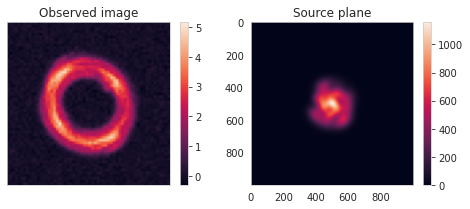

In [42]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(observed_img)
plt.title('Observed image')
plt.colorbar() 
plt.xticks([])
plt.yticks([])
plt.subplot(122)
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=False)
grid = np.linspace(-1,1,1000).astype(np.float32)
a, b = np.meshgrid(grid,grid)
ret = shp.light(a[np.newaxis,...,np.newaxis], b[np.newaxis,...,np.newaxis], **truth[1][0])
plt.imshow(np.squeeze(ret))
plt.title('Source plane')
plt.grid(False)
plt.colorbar()

Begin fitting.

In [43]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

See $\S2.3$: Maximum a Posteriori Estimate

In [44]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, 100, 1e-2/10)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=100, num_steps=150, seed=0)

  0%|          | 0/150 [00:00<?, ?it/s]

In [45]:
# Simulator to evaluate the log likelihood of 500 candidate solutions
lens_sim_100 = LensSimulator(phys_model, sim_config, bs=100)
lps = prob_model.log_prob(lens_sim_100, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

See $\S2.4$: Variational Inference

In [46]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 100, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=350)

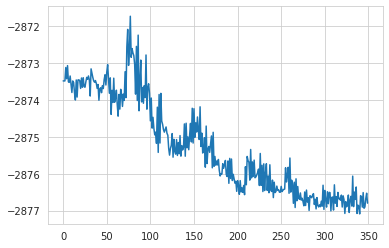

In [47]:
plt.plot(losses)

See $\S2.5$: Hamiltonian Monte Carlo

In [48]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

2022-05-04 15:22:10.817622: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


/global/homes/a/andigu/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [51]:
Rhat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, prob_model.bij.forward(samples))
ESS = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), prob_model.bij.forward(samples))
Rhat, ESS

([[{'theta_E': <tf.Tensor: shape=(), dtype=float32, numpy=0.9999266>,
    'gamma': <tf.Tensor: shape=(), dtype=float32, numpy=1.0014348>,
    'e2': <tf.Tensor: shape=(), dtype=float32, numpy=1.0009085>,
    'e1': <tf.Tensor: shape=(), dtype=float32, numpy=1.0008883>,
    'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=1.001364>,
    'center_x': <tf.Tensor: shape=(), dtype=float32, numpy=1.0013558>}],
  [{'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=1.0008352>,
    'center_x': <tf.Tensor: shape=(), dtype=float32, numpy=1.0018336>,
    'beta': <tf.Tensor: shape=(), dtype=float32, numpy=1.0015382>}]],
 [[{'theta_E': <tf.Tensor: shape=(), dtype=float32, numpy=22442.365>,
    'gamma': <tf.Tensor: shape=(), dtype=float32, numpy=15800.514>,
    'e2': <tf.Tensor: shape=(), dtype=float32, numpy=25876.135>,
    'e1': <tf.Tensor: shape=(), dtype=float32, numpy=25587.197>,
    'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=20601.943>,
    'center_x': <tf.Tensor: shape=(), 

In [ ]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[1][0]['beta'],
    x[1][0]['center_x'],
    x[1][0]['center_y'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth).numpy().flatten()
labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x_{epl}$', r'$y_{epl}$', r'$\beta$', r'$x_s$', r'$y_s$']
corner(physical_samples.reshape((len(labels),-1)).T, truths=markers, 
       show_titles=True, title_fmt='.4f',
       labels=labels);